## _*H2 ground state energy plot using different qubit mappings*_

This notebook demonstrates using Qiskit Chemistry to plot graphs of the ground state energy of the Hydrogen (H2) molecule over a range of inter-atomic distances with different fermionic mappings to quantum qubits.

This notebook has been written to use the PYSCF chemistry driver.

In [1]:
import numpy as np
import pylab
from qiskit import BasicAer
from qiskit.aqua import aqua_globals, QuantumInstance
from qiskit.aqua.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.aqua.components.optimizers import L_BFGS_B
from qiskit.circuit.library import TwoLocal
from qiskit.chemistry.drivers import PySCFDriver
from qiskit.chemistry.core import Hamiltonian, QubitMappingType

molecule = 'H .0 .0 -{0}; H .0 .0 {0}'

algorithms = ['VQE', 'NumPyMinimumEigensolver']
mappings   = [QubitMappingType.JORDAN_WIGNER,
              QubitMappingType.PARITY,
              QubitMappingType.BRAVYI_KITAEV]
start = 0.5  # Start distance
by    = 0.5  # How much to increase distance by
steps = 20   # Number of steps to increase by
energies  = np.empty([len(mappings), len(algorithms), steps+1])
hf_energies = np.empty(steps+1)
distances = np.empty(steps+1)

aqua_globals.random_seed = 50

print('Processing step __', end='')
for i in range(steps+1):
    print('\b\b{:2d}'.format(i), end='', flush=True)
    d = start + i*by/steps 
    for j in range(len(algorithms)):
        for k in range(len(mappings)): 
            driver = PySCFDriver(molecule.format(d/2), basis='sto3g')
            qmolecule = driver.run()
            operator =  Hamiltonian(qubit_mapping=mappings[k], two_qubit_reduction=False)
            qubit_op, aux_ops = operator.run(qmolecule)
            if algorithms[j] == 'NumPyMinimumEigensolver':
                result = NumPyMinimumEigensolver(qubit_op).run()
            else:
                optimizer = L_BFGS_B(maxfun=2500)
                var_form = TwoLocal(qubit_op.num_qubits, ['ry', 'rz'], 'cz', reps=5)
                algo = VQE(qubit_op, var_form, optimizer)
                result = algo.run(QuantumInstance(BasicAer.get_backend('statevector_simulator'),
                                    seed_simulator=aqua_globals.random_seed,
                                    seed_transpiler=aqua_globals.random_seed))

            result = operator.process_algorithm_result(result)
            energies[k][j][i] = result.energy
            hf_energies[i] = result.hartree_fock_energy  # Independent of algorithm & mapping
    distances[i] = d
print(' --- complete')

print('Distances: ', distances)
print('Energies:', energies)
print('Hartree-Fock energies:', hf_energies)


Processing step 20 --- complete
Distances:  [0.5   0.525 0.55  0.575 0.6   0.625 0.65  0.675 0.7   0.725 0.75  0.775
 0.8   0.825 0.85  0.875 0.9   0.925 0.95  0.975 1.   ]
Energies: [[[-1.05515979 -1.0759134  -1.08560852 -1.0915705  -1.11628601
   -1.12415219 -1.11299655 -1.11597526 -1.13618112 -1.13722137
   -1.13711604 -1.13604126 -1.13414766 -1.13155071 -1.10251055
   -1.09745432 -1.12056028 -1.11609624 -1.11133942 -1.07300676
   -1.10115028]
  [-1.05515979 -1.07591366 -1.09262991 -1.10591805 -1.11628601
   -1.12416092 -1.12990478 -1.13382622 -1.13618945 -1.13722138
   -1.13711707 -1.13604436 -1.13414767 -1.13155121 -1.12836188
   -1.12467175 -1.12056028 -1.11609624 -1.11133942 -1.10634211
   -1.10115033]]

 [[-1.05515735 -0.38515209 -1.0926299  -0.43863366 -0.46025198
   -1.1241609  -1.12990477 -1.13382616 -1.13618945 -1.13722138
   -1.13711705 -1.13604435 -1.13414767 -1.1315512  -1.12836188
   -1.12467175 -1.12056028 -1.11609619 -1.11133941 -1.10634211
   -1.10115033]
  [-1.05515

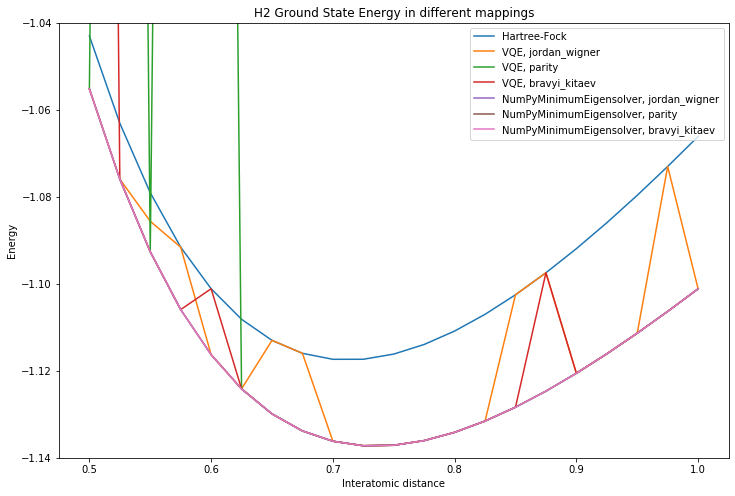

In [2]:
pylab.rcParams['figure.figsize'] = (12, 8)
pylab.ylim(-1.14, -1.04)
pylab.plot(distances, hf_energies, label='Hartree-Fock')
for j in range(len(algorithms)):
    for k in range(len(mappings)):
        pylab.plot(distances, energies[k][j], label=algorithms[j] + ", " + mappings[k].value)
pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.title('H2 Ground State Energy in different mappings')
pylab.legend(loc='upper right')
pylab.show()

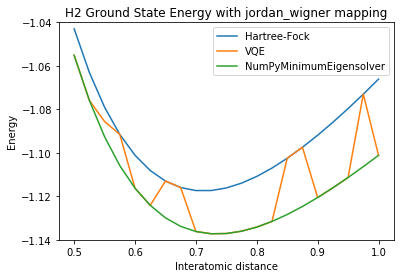

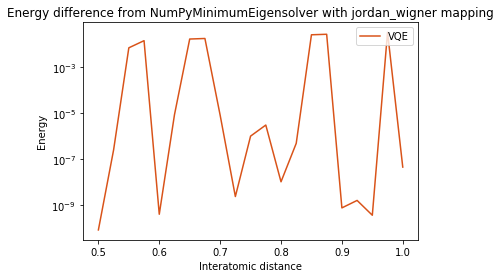

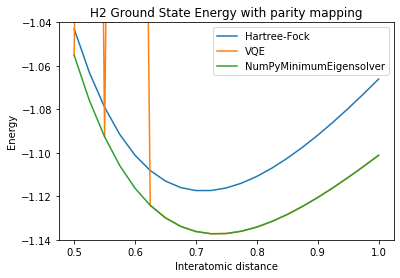

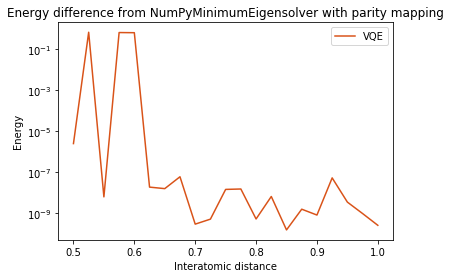

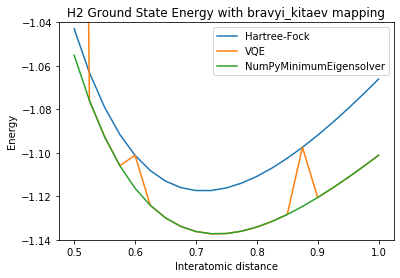

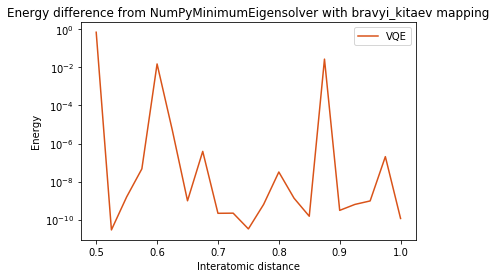

In [3]:
pylab.rcParams['figure.figsize'] = (6, 4)
for k in range(len(mappings)):
    pylab.ylim(-1.14, -1.04)
    pylab.plot(distances, hf_energies, label='Hartree-Fock')
    for j in range(len(algorithms)):
        pylab.plot(distances, energies[k][j], label=algorithms[j])
    pylab.xlabel('Interatomic distance')
    pylab.ylabel('Energy')
    pylab.title('H2 Ground State Energy with {} mapping'.format(mappings[k].value))
    pylab.legend(loc='upper right')
    pylab.show()
    
    #pylab.plot(distances, np.subtract(hf_energies, energies[k][1]), label='Hartree-Fock')
    pylab.plot(distances, np.subtract(energies[k][0], energies[k][1]), color=[0.8500, 0.3250, 0.0980], label='VQE')
    pylab.xlabel('Interatomic distance')
    pylab.ylabel('Energy')
    pylab.yscale('log')
    pylab.title('Energy difference from NumPyMinimumEigensolver with {} mapping'.format(mappings[k].value))
    pylab.legend(loc='upper right')
    pylab.show()